In [ ]:
# The code was removed by Watson Studio for sharing.

# Payment Plan Campaign

Jupiter Energy is the leading supplier of clean, renewable energy for the greater Boston area, servicing nearly 5 million customers across 4 counties. To better serve their clients, especially those facing financial hardship, Jupiter is launching a new set of electricity rates and payment plans. These new plans will significantly lower the total cost of energy for their clients in need.

Your task is to identify the customers who could benefit from the new plans.

In this Python 3.7 notebook, you'll improve the quality of the data and then build a machine learning model to determine which clients should be offered the new payment plans because they are likely to miss payments. You’ll be guided through these steps:

- Step 1: Load the data
- Step 2: Explore the data
- Step 3: Prepare the data
- Step 4: Build and train models
- Step 5: Evaluate the models
- Step 6: Predict potential missed payments
- Step 7: Deploy the model (Optional)


#### Insert a project token

When you import this project from the Watson Studio Gallery, a token should be automatically generated and inserted at the top of this notebook as a code cell such as the one below:

```python
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='YOUR_PROJECT_ID', project_access_token='YOUR_PROJECT_TOKEN')
pc = project.project_context
```

If you do not see the cell above, follow these steps to enable the notebook to access the dataset from the project's resources:

* Click on `More -> Insert project token` in the top-right menu section

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

* This should insert a cell at the top of this notebook similar to the example given above.

  > If an error is displayed indicating that no project token is defined, follow [these instructions](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html?audience=wdp&context=data).

* Run the newly inserted cell before proceeding with the notebook execution below

## Import libraries

Many popular open source libraries are pre-installed on Cloud Pak for Data platform environments. All you have to do is import them. If a library is not preinstalled, you can add it through the notebook or by adding a customization to the environment in which the notebook runs.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

%matplotlib inline
plt.style.use('ggplot')

## Step 1: Load and access the data

In [3]:
df = pd.read_csv(project.get_file('Historical-Customer-Payments-Prepared.csv'))
df.head()

,CUSTOMER_ID,OVERDUE_BALANCE,BASE_USAGE,CREDIT_HISTORY,ALTERNATE_USAGE,STANDING_CHARGE,BASE_CHARGE,ALTERNATE_CHARGE,LEVY,TAX,...,MISSED_PAYMENT,BILLING_MONTH,RATIO_THIS_MONTH_BASE_USAGE_VS_LAST_MONTH,RATIO_THIS_MONTH_BASE_USAGE_VS_AVG_LOOKBACK_WINDOW,RATIO_THIS_MONTH_ALTERNATE_USAGE_VS_LAST_MONTH,RATIO_THIS_MONTH_ALTERNATE_USAGE_VS_AVG_LOOKBACK_WINDOW,RATIO_THIS_MONTH_TOTAL_TO_PAY_VS_LAST_MONTH,RATIO_THIS_MONTH_TOTAL_TO_PAY_VS_AVG_LOOKBACK_WINDOW,NUM_MISSED_PAYMENTS_LOOKBACK_WINDOW,BILLING_MONTH_NUMBER
0,341,0.0,457.56,A,112.62,7.49,67.44,10.16,2.55,17.18,...,Paid,201904,1.010066,0.968613,1.003296,0.963031,1.008369,0.970586,0,4
1,374,0.0,1161.67,A,0.00,5.62,150.32,0.00,4.68,31.48,...,Paid,201903,0.865942,0.906075,0.000000,0.000000,0.870136,0.909148,0,3
2,398,0.0,449.21,A,0.00,5.62,58.13,0.00,1.91,12.87,...,Paid,201904,1.005101,0.949196,0.000000,0.000000,1.004605,0.953458,0,4
3,427,0.0,888.02,A,0.00,5.62,114.91,0.00,3.62,24.33,...,Paid,201901,0.893290,0.955593,0.000000,0.000000,0.897757,0.957585,0,1
4,435,0.0,670.17,B,0.00,14.87,86.72,0.00,3.05,20.51,...,Paid,201808,3.169702,0.000000,0.000000,0.000000,2.405805,0.000000,0,8


### Alternative load data method

Use the **Insert to code** function to automatically generate code that loads the data and shows the first 5 rows in a pandas DataFrame:
1. Click the **Find and add data** icon on the notebook action bar.
2. From the **Insert to code** menu for `Historical-Customer-Payments-Prepared.csv`, choose **pandas DataFrame**.
3. Rename the dataframe from `df_data_1` to `df` in the second to last link and then run the cell.

In [4]:
# rename df_data_X to df

## Step 2: Explore the data

You can use plots, graphs, and summary statistics to systematically go through the data. For example, you can plot the distribution of all variables, plot a time series of the data, transform variables, look at all pairwise relationship between variables using scatterplot matrices, and generate summary statistics for all of them. Here are some of these methods.

### Check the summary statistics

In [5]:
df.describe()

,CUSTOMER_ID,OVERDUE_BALANCE,BASE_USAGE,ALTERNATE_USAGE,STANDING_CHARGE,BASE_CHARGE,ALTERNATE_CHARGE,LEVY,TAX,TOTAL_NET,...,IN_WARRANTY,BILLING_MONTH,RATIO_THIS_MONTH_BASE_USAGE_VS_LAST_MONTH,RATIO_THIS_MONTH_BASE_USAGE_VS_AVG_LOOKBACK_WINDOW,RATIO_THIS_MONTH_ALTERNATE_USAGE_VS_LAST_MONTH,RATIO_THIS_MONTH_ALTERNATE_USAGE_VS_AVG_LOOKBACK_WINDOW,RATIO_THIS_MONTH_TOTAL_TO_PAY_VS_LAST_MONTH,RATIO_THIS_MONTH_TOTAL_TO_PAY_VS_AVG_LOOKBACK_WINDOW,NUM_MISSED_PAYMENTS_LOOKBACK_WINDOW,BILLING_MONTH_NUMBER
count,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,...,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000
mean,490.374640,104.235187,707.898804,75.665865,11.102680,94.408573,6.825086,3.370072,22.678545,115.706643,...,0.481268,201856.495677,1.070404,0.773621,0.315780,0.238260,1.175593,0.954706,0.548991,6.351585
std,257.196621,281.736755,361.169441,138.777494,6.182669,46.753375,12.517728,1.528706,10.286960,52.484931,...,0.500009,46.950151,0.806273,0.468586,0.604928,0.438735,0.693846,0.715055,1.004919,3.538331
min,2.000000,0.000000,42.410000,0.000000,5.620000,5.490000,0.000000,0.420000,2.840000,14.510000,...,0.000000,201807.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,277.250000,0.000000,449.445000,0.000000,7.490000,60.372500,0.000000,2.260000,15.180000,77.442500,...,0.000000,201809.000000,0.924503,0.000000,0.000000,0.000000,0.941918,0.000000,0.000000,3.000000
50%,454.500000,0.000000,622.840000,0.000000,8.730000,84.935000,0.000000,3.000000,20.200000,103.065000,...,0.000000,201901.000000,1.006947,0.969429,0.000000,0.000000,1.065889,0.996291,0.000000,6.000000
75%,709.750000,91.342500,914.547500,116.340000,14.870000,121.112500,10.497500,4.147500,27.907500,142.390000,...,1.000000,201903.000000,1.098051,1.076586,0.901903,0.000000,1.355699,1.213487,1.000000,9.000000
max,998.000000,2811.040000,2192.400000,980.610000,35.000000,283.700000,88.450000,9.560000,64.320000,328.190000,...,1.000000,201906.000000,9.527063,1.519787,5.521665,1.544680,6.079493,2.795013,3.000000,12.000000


### Check the target variable `MISSED_PAYMENT`

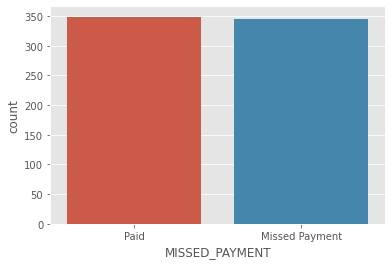

Paid              349
Missed Payment    345
Name: MISSED_PAYMENT, dtype: int64

In [6]:
sns.countplot(x=df["MISSED_PAYMENT"])
plt.show()
df["MISSED_PAYMENT"].value_counts()

In the above chart, you can see that `MISSED_PAYMENT` is a binary variable with a fairly uniform distribution. This column is your target variable because whether a customer has missed a previous payment is the best indicator of whether they will miss a future payment.

### Check the correlation between numerical features to understand relationships in the data

Text(0.5, 1.0, 'CORRELATION HEATMAP')

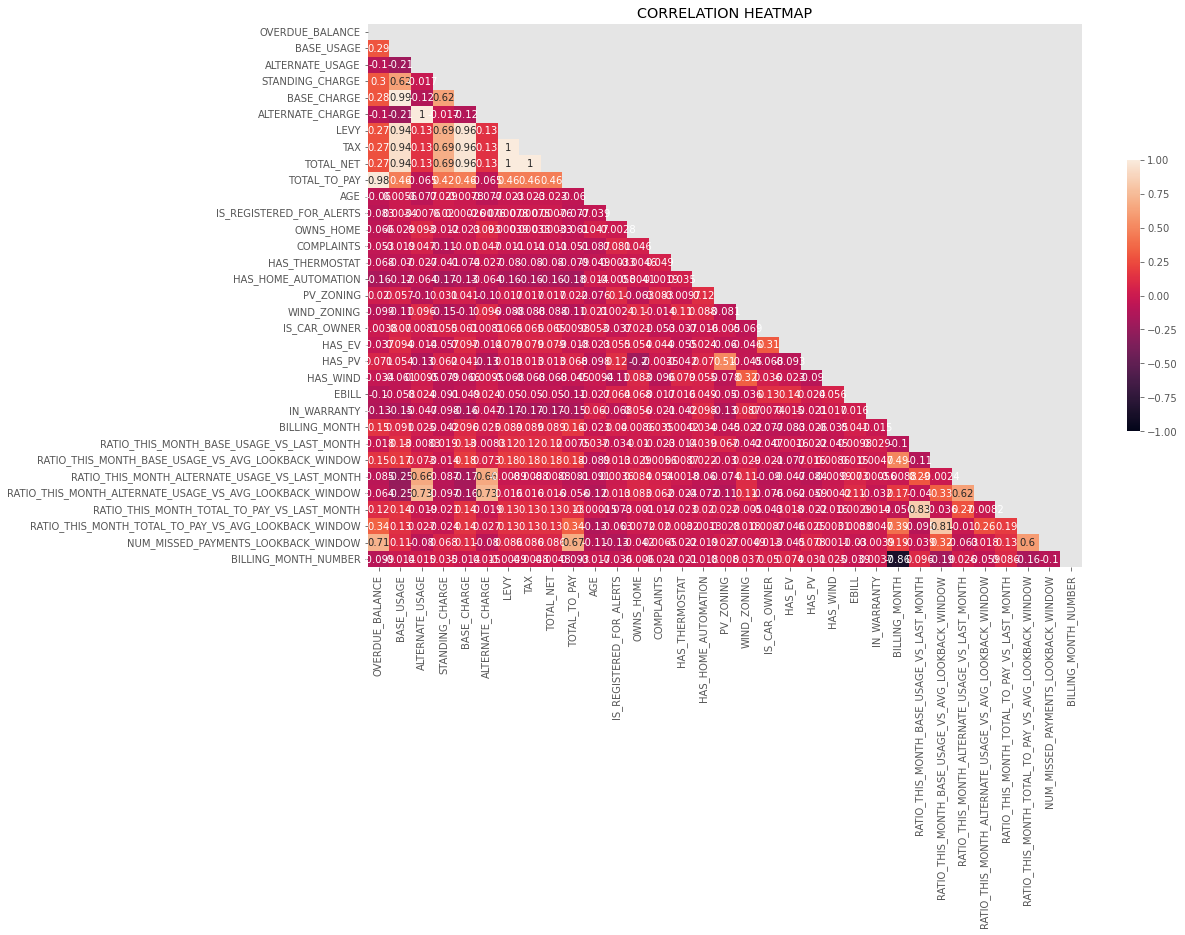

In [7]:
plt.figure(figsize=(16, 10))
corr = df.drop(["CUSTOMER_ID"], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cbar_kws={"shrink": .5})
heatmap.set_title('CORRELATION HEATMAP')

## Step 3: Prepare the data

To prepare your data for model building, you can use data pre-processing techniques, including the addition, deletion, or transformation of training data. Here you’ll set up the split between the training and testing data and transform some string data to numeric data to make it quantifiable. 

In [8]:
X = df.drop(["CUSTOMER_ID","MISSED_PAYMENT"], axis=1)
y = df["MISSED_PAYMENT"]

labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.20)

In [9]:
ordinal_cols_mapping = [{
    "col":"SMART_METER_COMMENTS",    
    "mapping": [('Positive', 1), ('Negative', -1), ('Neutral', 0)]
}]

categorical_columns = X.drop(["SMART_METER_COMMENTS"], axis=1).select_dtypes(include='object').columns.tolist()
numerical_columns = X.select_dtypes(include=np.number).columns.tolist()

column_transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_columns), 
    (OrdinalEncoder(), ["SMART_METER_COMMENTS"]),
    (MinMaxScaler(), numerical_columns), 
    remainder='passthrough')

## Step 4: Build and train models

To find the best model, you’ll train multiple candidate models. There are many predictive modeling algorithms to choose from. For this type of problem, these are the best choices:

- Random Forest
- Logistic Regression
- XGBoost

### Random Forest

In [10]:
rf_pipeline = make_pipeline(column_transformer, RandomForestClassifier(n_estimators=100))
rf_pipeline.fit(X_train, y_train)

y_rf_score = rf_pipeline.score(X_test, y_test)
print("Random Forest model accuracy:", np.round(y_rf_score, decimals=2))

Random Forest model accuracy: 0.91


### Logistic Regression

In [11]:
lr_pipeline = make_pipeline(column_transformer, LogisticRegression())
lr_pipeline.fit(X_train, y_train)

y_lr_score = lr_pipeline.score(X_test, y_test)
print("Logistic Regression model accuracy:", np.round(y_lr_score, decimals=2))

Logistic Regression model accuracy: 0.9


### XGBoost

In [12]:
xgb_pipeline = make_pipeline(column_transformer, XGBClassifier(use_label_encoder=False))

In [13]:
xgb_pipeline.fit(X_train, y_train)

[21:14:15] WARNING: /opt/conda/conda-bld/xgboost-ext_1641442594597/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CREDIT_HISTORY', 'CITY',
                                                   'MARITAL_STATUS',
                                                   'EDUCATION', 'SEGMENT',
                                                   'EMPLOYMENT',
                                                   'BUILDING_TYPE']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['SMART_METER_COMMENTS']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                            

In [14]:
y_xgb_score = xgb_pipeline.score(X_test, y_test)
print("XGBoost model accuracy:", np.round(y_xgb_score, decimals=2))

XGBoost model accuracy: 0.88


## Step 5: Evaluate the model

Now you must evaluate your candidate models. A useful method for evaluating the performance of a model is measuring the area under the Receiver Operating Characteristic (ROC) curve. An ROC curve plots the true-positive rate (sensitivity) versus the false-positive rate (specificity). 

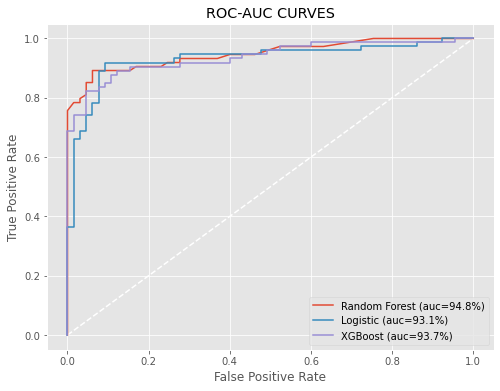

In [15]:
y_rf_probs = rf_pipeline.predict_proba(X_test)[::,1]
y_lr_probs = lr_pipeline.predict_proba(X_test)[::,1]
y_xgb_probs = xgb_pipeline.predict_proba(X_test)[::,1]

rf_auc = roc_auc_score(y_test, y_rf_probs)
lr_auc = roc_auc_score(y_test, y_lr_probs)
xgb_auc = roc_auc_score(y_test, y_xgb_probs)

rf_fpr, rf_tpr, _ = roc_curve(y_test, y_rf_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_lr_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_xgb_probs)

plt.figure(figsize=(8, 6))

plt.plot([0,1],[0,1],'w--')
plt.plot(rf_fpr, rf_tpr, label='Random Forest (auc={:.1%})'.format(rf_auc))
plt.plot(lr_fpr, lr_tpr, label='Logistic (auc={:.1%})'.format(lr_auc))
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost (auc={:.1%})'.format(xgb_auc))

plt.title('ROC-AUC CURVES')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In the chart above, each line is color-coded by model. The legend shows that Random Forest has the highest ROC-AUC score, meaning it yields the best performance out of the three models. 

## Step 6: Predict potential missed payments

Use the Random Forest model to predict which of the 10 randomly selected customers from the original data set might miss a payment.

In [16]:
df_sample = df.sample(n = 10)
df_sample.rename(columns={'MISSED_PAYMENT': 'Actual'}, inplace=True)

y_proba = rf_pipeline.predict_proba(df_sample.drop(["CUSTOMER_ID","Actual"], axis=1))
df_sample["Prediction"] = labelencoder_y.inverse_transform(y_proba.argmax(axis=-1))
df_sample["Probability"] = y_proba.max(axis=-1)

print("Predicting potential missed payments for 10 customers")
df_sample[["CUSTOMER_ID", "Prediction", "Probability"] + X.columns.tolist()]

Predicting potential missed payments for 10 customers


,CUSTOMER_ID,Prediction,Probability,OVERDUE_BALANCE,BASE_USAGE,CREDIT_HISTORY,ALTERNATE_USAGE,STANDING_CHARGE,BASE_CHARGE,ALTERNATE_CHARGE,...,BUILDING_TYPE,BILLING_MONTH,RATIO_THIS_MONTH_BASE_USAGE_VS_LAST_MONTH,RATIO_THIS_MONTH_BASE_USAGE_VS_AVG_LOOKBACK_WINDOW,RATIO_THIS_MONTH_ALTERNATE_USAGE_VS_LAST_MONTH,RATIO_THIS_MONTH_ALTERNATE_USAGE_VS_AVG_LOOKBACK_WINDOW,RATIO_THIS_MONTH_TOTAL_TO_PAY_VS_LAST_MONTH,RATIO_THIS_MONTH_TOTAL_TO_PAY_VS_AVG_LOOKBACK_WINDOW,NUM_MISSED_PAYMENTS_LOOKBACK_WINDOW,BILLING_MONTH_NUMBER
319,729,Paid,0.98,0.0,722.14,A,0.00,14.87,93.44,0.00,...,Apartment,201906,0.889390,0.875162,0.000000,0.000000,0.903080,0.890404,0,6
428,752,Missed Payment,0.96,0.0,585.46,C,0.00,5.62,75.76,0.00,...,Apartment,201902,1.132286,1.106318,0.000000,0.000000,1.121992,0.830755,1,2
672,282,Missed Payment,0.78,20.5,530.38,A,0.00,8.73,68.63,0.00,...,Condominium,201808,8.677683,0.000000,0.000000,0.000000,5.648780,0.000000,0,8
216,856,Paid,1.00,0.0,531.06,A,0.00,8.73,68.72,0.00,...,Apartment,201906,1.084859,0.992067,0.000000,0.000000,1.074558,0.992958,0,6
239,442,Paid,0.99,0.0,551.75,A,0.00,8.73,71.40,0.00,...,Apartment,201811,1.121854,1.071366,0.000000,0.000000,1.107235,1.063151,0,11
208,580,Paid,0.99,0.0,479.90,A,0.00,8.73,62.10,0.00,...,Apartment,201901,0.907132,1.002381,0.000000,0.000000,0.917648,1.002067,0,1
402,348,Missed Payment,0.91,0.0,1024.98,E,0.00,17.45,132.63,0.00,...,Condominium,201808,1.181915,0.000000,0.000000,0.000000,1.157381,0.000000,0,8
261,961,Missed Payment,0.64,0.0,298.70,B,206.26,7.49,44.03,18.60,...,Dormitory,201904,0.925541,0.898166,0.975040,0.956103,0.945801,0.923028,0,4
187,105,Paid,0.67,0.0,255.42,B,187.95,8.95,37.65,16.95,...,Townhouse,201810,0.883409,1.177992,0.900834,1.204885,0.902895,1.155913,0,10
77,439,Paid,0.99,0.0,1023.98,A,213.68,18.18,150.93,19.27,...,Apartment,201901,1.042357,1.161678,1.019125,1.057525,1.035703,1.132583,0,1


The `Prediction` column contains the prediction results generated from the Random Forest model based on the customer payment history.
The `Probability` column contains the probability of each prediction.

## Step 7: Deploy the model (optional)

Deployment is the final stage of the lifecycle of a model or script. In a notebook, you can use the IBM Watson Machine Learning Python client library to deploy the trained machine learning model to IBM Watson Machine Learning.

Check out our online documentation, <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/wmls/wmls-deploy-overview.html" target="_blank" rel="noopener noreferrer">Deploying assets</a>, for more samples, tutorials, and information.


## Summary

In this notebook, you loaded and accessed the available data, prepared the data, and built a machine learning model to determine which clients should be offered payment plans.

### Author

**Eric Dong** is a Data Scientist at IBM.

***
Copyright © IBM Corp. 2021. This notebook and its source code are released under the terms of the MIT License.